In [11]:
import numpy as np
import TensorFrost as tf
import matplotlib.pyplot as plt

tf.initialize(tf.cpu)

def reverseBits(num, bits):
    reverse_num = tf.int(tf.reversebits(tf.uint(num))) >> (32 - bits)
    return reverse_num + ((num >> bits) << bits)

def getIndexPair(i, it):
    k1 = reverseBits(2*i, it+1)
    k2 = k1 + (1 << it)
    return [k1, k2]

#in-place FFT implementation
def FFT():
    Signal = tf.input([-1], tf.float32)
    N = Signal.shape[0]
    
    it_num = tf.int(tf.floor(tf.log2(tf.float(N))))-1
    Output = tf.buffer([N, 2], tf.float32)

    i, = tf.indices([N/2])

    k1, k2 = getIndexPair(i, it_num)
    S1 = Signal[k1]
    S2 = Signal[k2]
    Output[2*i, 0] = S1 + S2
    Output[2*i, 1] = 0.0
    Output[2*i+1, 0] = S1 - S2
    Output[2*i+1, 1] = 0.0

    with tf.loop(1, it_num+1) as it:
        k1, k2 = getIndexPair(i, it)
        k3 = (k1 & ((1 << it) - 1)) * (1 << (it_num - it))
        alpha = - 2 * np.pi * tf.float(k3) / tf.float(N)
        Re1 = Output[k2, 0]
        Im1 = Output[k2, 1]
        Re2 = Output[k1, 0]
        Im2 = Output[k1, 1]
        C = tf.cos(alpha)
        S = tf.sin(alpha)
        m = C * Re1 - S * Im1
        n = S * Re1 + C * Im1
        Output[k1, 0] = Re2 + m
        Output[k1, 1] = Im2 + n
        Output[k2, 0] = Re2 - m
        Output[k2, 1] = Im2 - n

    return [Output]

fft = tf.compile(FFT)

FFT:
  Kernel count: 2
  Intermediate buffers: 0
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 507
  IR Compile time: 3.446500 ms
  Compiler time: 1379.151123 ms



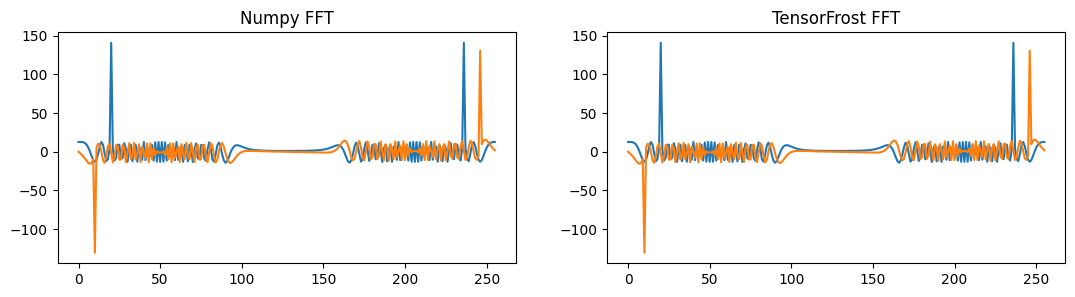

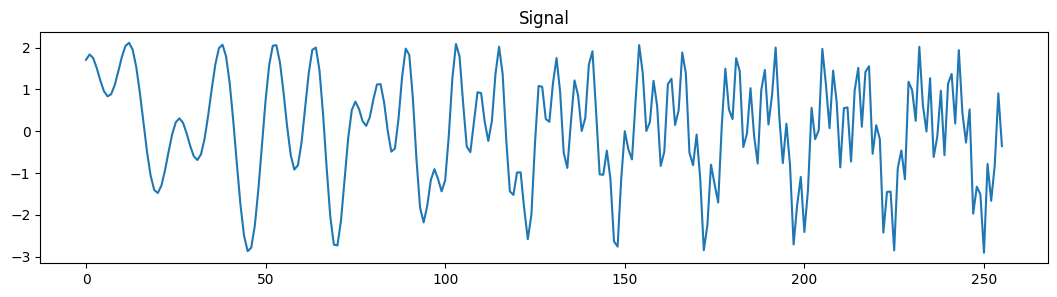

In [12]:
#test signal
N = 256
t = np.arange(N)
signal = np.sin(10 * 2 * np.pi * t / N).astype(np.float32)
signal += np.cos(20 * 2 * np.pi * t / N)
signal += np.sin(50 * 2 * np.pi * t * t / (N * N) + np.pi/4)

#run the FFT
signal_tf = tf.tensor(signal)
Output_tf, = fft(signal_tf)
output = Output_tf.numpy

#compare with numpy
np_fft = np.fft.fft(signal)

#plot the results side by side
plt.figure(figsize=(13, 3))
plt.subplot(1, 2, 1)
plt.plot(np.real(np_fft), label="Real")
plt.plot(np.imag(np_fft), label="Imaginary")
plt.title("Numpy FFT")
plt.subplot(1, 2, 2)
plt.plot(output[:, 0], label="Real")
plt.plot(output[:, 1], label="Imaginary")
plt.title("TensorFrost FFT")
plt.show()

#plot signal
plt.figure(figsize=(13, 3))
plt.plot(signal)
plt.title("Signal")
plt.show()